<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/UN_decade_banner.png' align='right' width='100%'/>

<a href="../../../Index.ipynb"><< Index</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT <br>
**Authors:** B. Loveday (Innoflair UG / EUMETSAT), Hayley Evers-King (EUMETSAT)

<div class="alert alert-block alert-success">
<h3>Ocean case studies</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>

There are no prerequisite notebooks for this module, but you may wish to look at the following notebooks on using OLCI data; <br>
- **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-olci" target="_blank">Learn OLCI (EUMETSAT Gitlab)</a>**

For more contextual information, users should refer to the following case study where the image we generate here is published:
- **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-olci" target="_blank">Coastal deoxygenation: South African red tides</a>**<<FIX

</div>
<hr>

# Red tides in South African Waters
<font color="#138D75">**UN Ocean Decade Challenge 3: Sustainably feed the global population**</font>

### Data used

| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 OLCI level-2 full resolution | EO:EUM:DAT:0407 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC?query=OLCI&filter=satellite__Sentinel-3&filter=instrument__OLCI&filter=processingLevel__Level%202%20Data&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:OL_2_WFR___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3AOL_1_EFR___" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know how to ;
* download OLCI Level-2 data for South Africa's west coast on February 26th, 2022
* plot an OLCI band ratio chlorophyll product over the region


### Outline

This code will replicate figure ??? from this case study; **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-olci" target="_blank">Coastal deoxygenation: South African red tides</a>**<<FIX.

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Acquiring OLCI data](#section1)
 2. [Reading OLCI reflectance data](#section2)
 3. [Plotting OLCI data](#section3)

<hr>

In [43]:
import shutil
import os
import json
import zipfile
import eumdac
import warnings
import xarray as xr
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import glob
import eumartools
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patheffects as PathEffects
import cartopy.crs as ccrs

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Acquiring OLCI data
[Back to top](#TOC_TOP)

</div>

We will begin by creating a directory for our downloaded data

In [2]:
# Create a download directory for our OLCI products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

We are going to retrieve the OLCI data from the EUMETSAT Data Store. Collections are stored according to their `collection id`, which for OLCI Level-2 full resolution products is `EO:EUM:DAT:0407` (as specified in the "Data Used" section above). We will also provide the relevant products we want from this collection, which in this case is two granules. For more information on how to search for the data you want, please see the Learn OLCI Gitlab link above.

In [3]:
collection_id = 'EO:EUM:DAT:0407'
product_list = ['S3A_OL_2_WFR____20220220T080053_20220220T080353_20220221T184925_0179_082_149_3420_MAR_O_NT_003.SEN3',
                'S3A_OL_2_WFR____20220220T080353_20220220T080653_20220221T184943_0180_082_149_3600_MAR_O_NT_003.SEN3']

To access Sentinel-3 data from the <a href="https://data.eumetsat.int">EUMETSAT Data Store</a>, we will use the EUMETSAT Data Access Client (`eumdac`). If you are working with the recommended Anaconda Python distribution and used the supplied environment file (environment.yml) to build this python environment (as detailed in the README), you will already have installed this. If not, you can install eumdac using;

`conda install -c eumetsat eumdac`

However, you can also find the source code on the <a href="https://gitlab.eumetsat.int/eumetlab/data-services/eumdac">EUMETSAT gitlab</a>. Please visit the EUMETSAT user support confluence spaces for the the <a href="https://eumetsatspace.atlassian.net/wiki/spaces/DSDS/overview">Data Store</a> and <a href="https://eumetsatspace.atlassian.net/wiki/spaces/EUMDAC/overview">eumdac</a> for more information.

In order to allow us to download data from the Data Store via API, we need to provide our credentials. We can do this in two ways; either by creating a file called `.eumdac_credentials` in our home directory (*option 1 - recommended*) or by supplying our credentials directly in this script (*option 2*). 

#### Option 1: creating  `.eumdac_credentials` in our home directory

For most computer systems the home directory can be found at the path \user\username, /users/username, or /home/username depending on your operating system.

In this file we need to add the following information exactly as follows;

```
{
"consumer_key": "<your_consumer_key>",
"consumer_secret": "<your_consumer_secret>"
}
```

You must replace `<your_consumer_key>` and `<your_consumer_secret>` with the information you extract from https://api.eumetsat.int/api-key/. You will need a <a href="https://eoportal.eumetsat.int/">EUMETSAT Earth Observation Portal account</a> to access this link, and in order to see the information you must click the "Show hidden fields" button at the bottom of the page.

*Note: your key and secret are permanent, so you only need to do this once, but you should take care to never share them*

Make sure to save the file without any kind of extension. Once you have done this, you can read in your credentials using the commands in the following cell. These will be used to generate a time-limited token, which will refresh itself when it expires.

<div class="alert alert-warning" role="alert">
Optionally, you can provide your credentials directly as follows;
<br>

    
`token = eumdac.AccessToken((consumer_key, consumer_secret))`

<br> 
Note: this method is convenient in the short term, but is not really recommended as you have to put your key and secret in this notebook, and run the risk of accidentally sharing them. This method also requires you to authenticate on a notebook-by-notebook basis.

In [4]:
with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
    credentials = json.load(json_file)
    token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
    print(f"This token '{token}' expires {token.expiration}")

This token 'd228e25a-b31d-3f38-bce9-2afa2ac1e1bd' expires 2022-05-11 17:23:00.937572


Now we have a token, we can ask the Data Store for our specified products. The box below will download them in sequence, unzip them and tidy up.

In [5]:
datastore = eumdac.DataStore(token)

for product_id in product_list:
    print(f"Retrieving: {product_id} from {collection_id}")    

    selected_collection = datastore.get_collection(collection_id)
    selected_product = datastore.get_product(product_id=product_id, collection_id=collection_id)
    
    with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
        print(f'Downloading {fsrc.name}.')
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {fsrc.name} finished.')

    with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith(str(selected_product)):
                zip_ref.extract(file, download_dir)
        print(f'Unzipping of product {fdst.name} finished.')

    os.remove(fdst.name)

Retrieving: S3A_OL_2_WFR____20220220T080053_20220220T080353_20220221T184925_0179_082_149_3420_MAR_O_NT_003.SEN3 from EO:EUM:DAT:0407
Download of product S3A_OL_2_WFR____20220220T080053_20220220T080353_20220221T184925_0179_082_149_3420_MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /Users/benloveday/Code/Git_Reps/CMTS/internal/applications/ocean-case-studies/case_studies/UN_Ocean_Decade/Challenge03_sustainable_food/products/S3A_OL_2_WFR____20220220T080053_20220220T080353_20220221T184925_0179_082_149_3420_MAR_O_NT_003.SEN3.zip finished.
Retrieving: S3A_OL_2_WFR____20220220T080353_20220220T080653_20220221T184943_0180_082_149_3600_MAR_O_NT_003.SEN3 from EO:EUM:DAT:0407
Download of product S3A_OL_2_WFR____20220220T080353_20220220T080653_20220221T184943_0180_082_149_3600_MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /Users/benloveday/Code/Git_Reps/CMTS/internal/applications/ocean-case-studies/case_studies/UN_Ocean_Decade/Challenge03_sustainable_food/products/S3A_OL_2_WFR____2022

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Reading OLCI reflectance data
[Back to top](#TOC_TOP)

</div>

Blooms in the Benguela tend to be very high in biomass and have high Chlorophyll concentrations. Consequently, standard retrieval algorithms often do not perform well here. To get a better approximation we are going to use a red-band ratio algorithm based on the 665 n and 709 nm bands, that has been show to work well in the region (<a href="https://link.springer.com/chapter/10.1007/978-94-017-8008-7_10" target="_blank">Bernard et al., 2014</a>). For this, we need to read in the two reflectance bands, the geolocation points and the flag field. The latter will allow us to make out erroneous points (e.g. due to cloud). The band ratio can be calculated using;

$[Chl-a] = 227.25 * e^{-2.815 *(Ref_{665}/Ref_{709})}$

We will switch between the use of the standard OC4ME algorithm to the band ration algorithm where the chlorophyll concentration is higher than 10 in the former.

In [6]:
# makes area average
subset_box_lons = [17, 17, 19, 19, 17]
subset_box_lats = [-33, -31, -31, -33, -33]

In [7]:
SAFE_directories = glob.glob(os.path.join(download_dir,'*.SEN3'))

In [8]:
chls = []
lons = []
lats = []
land_masks = []

for SAFE_directory in SAFE_directories:

    # read and subset coords
    geo_file = os.path.join(SAFE_directory,'geo_coordinates.nc')
    geo_fid = xr.open_dataset(geo_file)
    lon = geo_fid.longitude.data
    lat = geo_fid.latitude.data
    ii, jj, region_mask = eumartools.subset_image(lon, lat, subset_box_lons, subset_box_lats) 
    geo_fid.close()
    lons.append(lon[min(jj):max(jj), min(ii):max(ii)])
    lats.append(lat[min(jj):max(jj), min(ii):max(ii)])

    # read and subset band vars
    band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'Oa*.nc')))
    ref_665 = np.array(band_vars['Oa08_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    ref_709 = np.array(band_vars['Oa11_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    band_vars.close()
    
    # read and subset OC4ME CHL
    chl_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'chl_oc4me*.nc')))
    chl = np.array(chl_vars['CHL_OC4ME'].data[min(jj):max(jj), min(ii):max(ii)])
    chl_vars.close()    
    
    # reading masks: example cloud
    flag_file = os.path.join(SAFE_directory,'wqsf.nc')
    flag_mask = eumartools.flag_mask(flag_file, 'WQSF',
                                     ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                      'LAND', 'INVALID', 'HISOLZEN','HIGHGLINT',
                                      'COSMETIC','SUSPECT','SATURATED'])

    flag_mask = flag_mask.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_mask[flag_mask == 0.0] = np.nan

    # calculate band ratio
    ref_665[flag_mask == 1] = np.nan
    ref_709[flag_mask == 1] = np.nan
    band_ratio = np.log10(227.25 * np.exp(-2.815*ref_665/ref_709))
    chl[flag_mask == 1] = np.nan
    chl[chl > 10] = band_ratio[chl > 10]
    chls.append(chl)

    # reading masks: example land
    land_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND'])
    land_mask = land_mask.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    land_mask[land_mask == 0.0] = np.nan
    land_masks.append(land_mask)

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Plotting OLCI data
[Back to top](#TOC_TOP)

</div>

Now that we have calculated our band ratio for each product we will plot them using the box below. Thsi plot routine will render each image in succession and then embellish with a few annotations at the end. It will save the output image as a png.

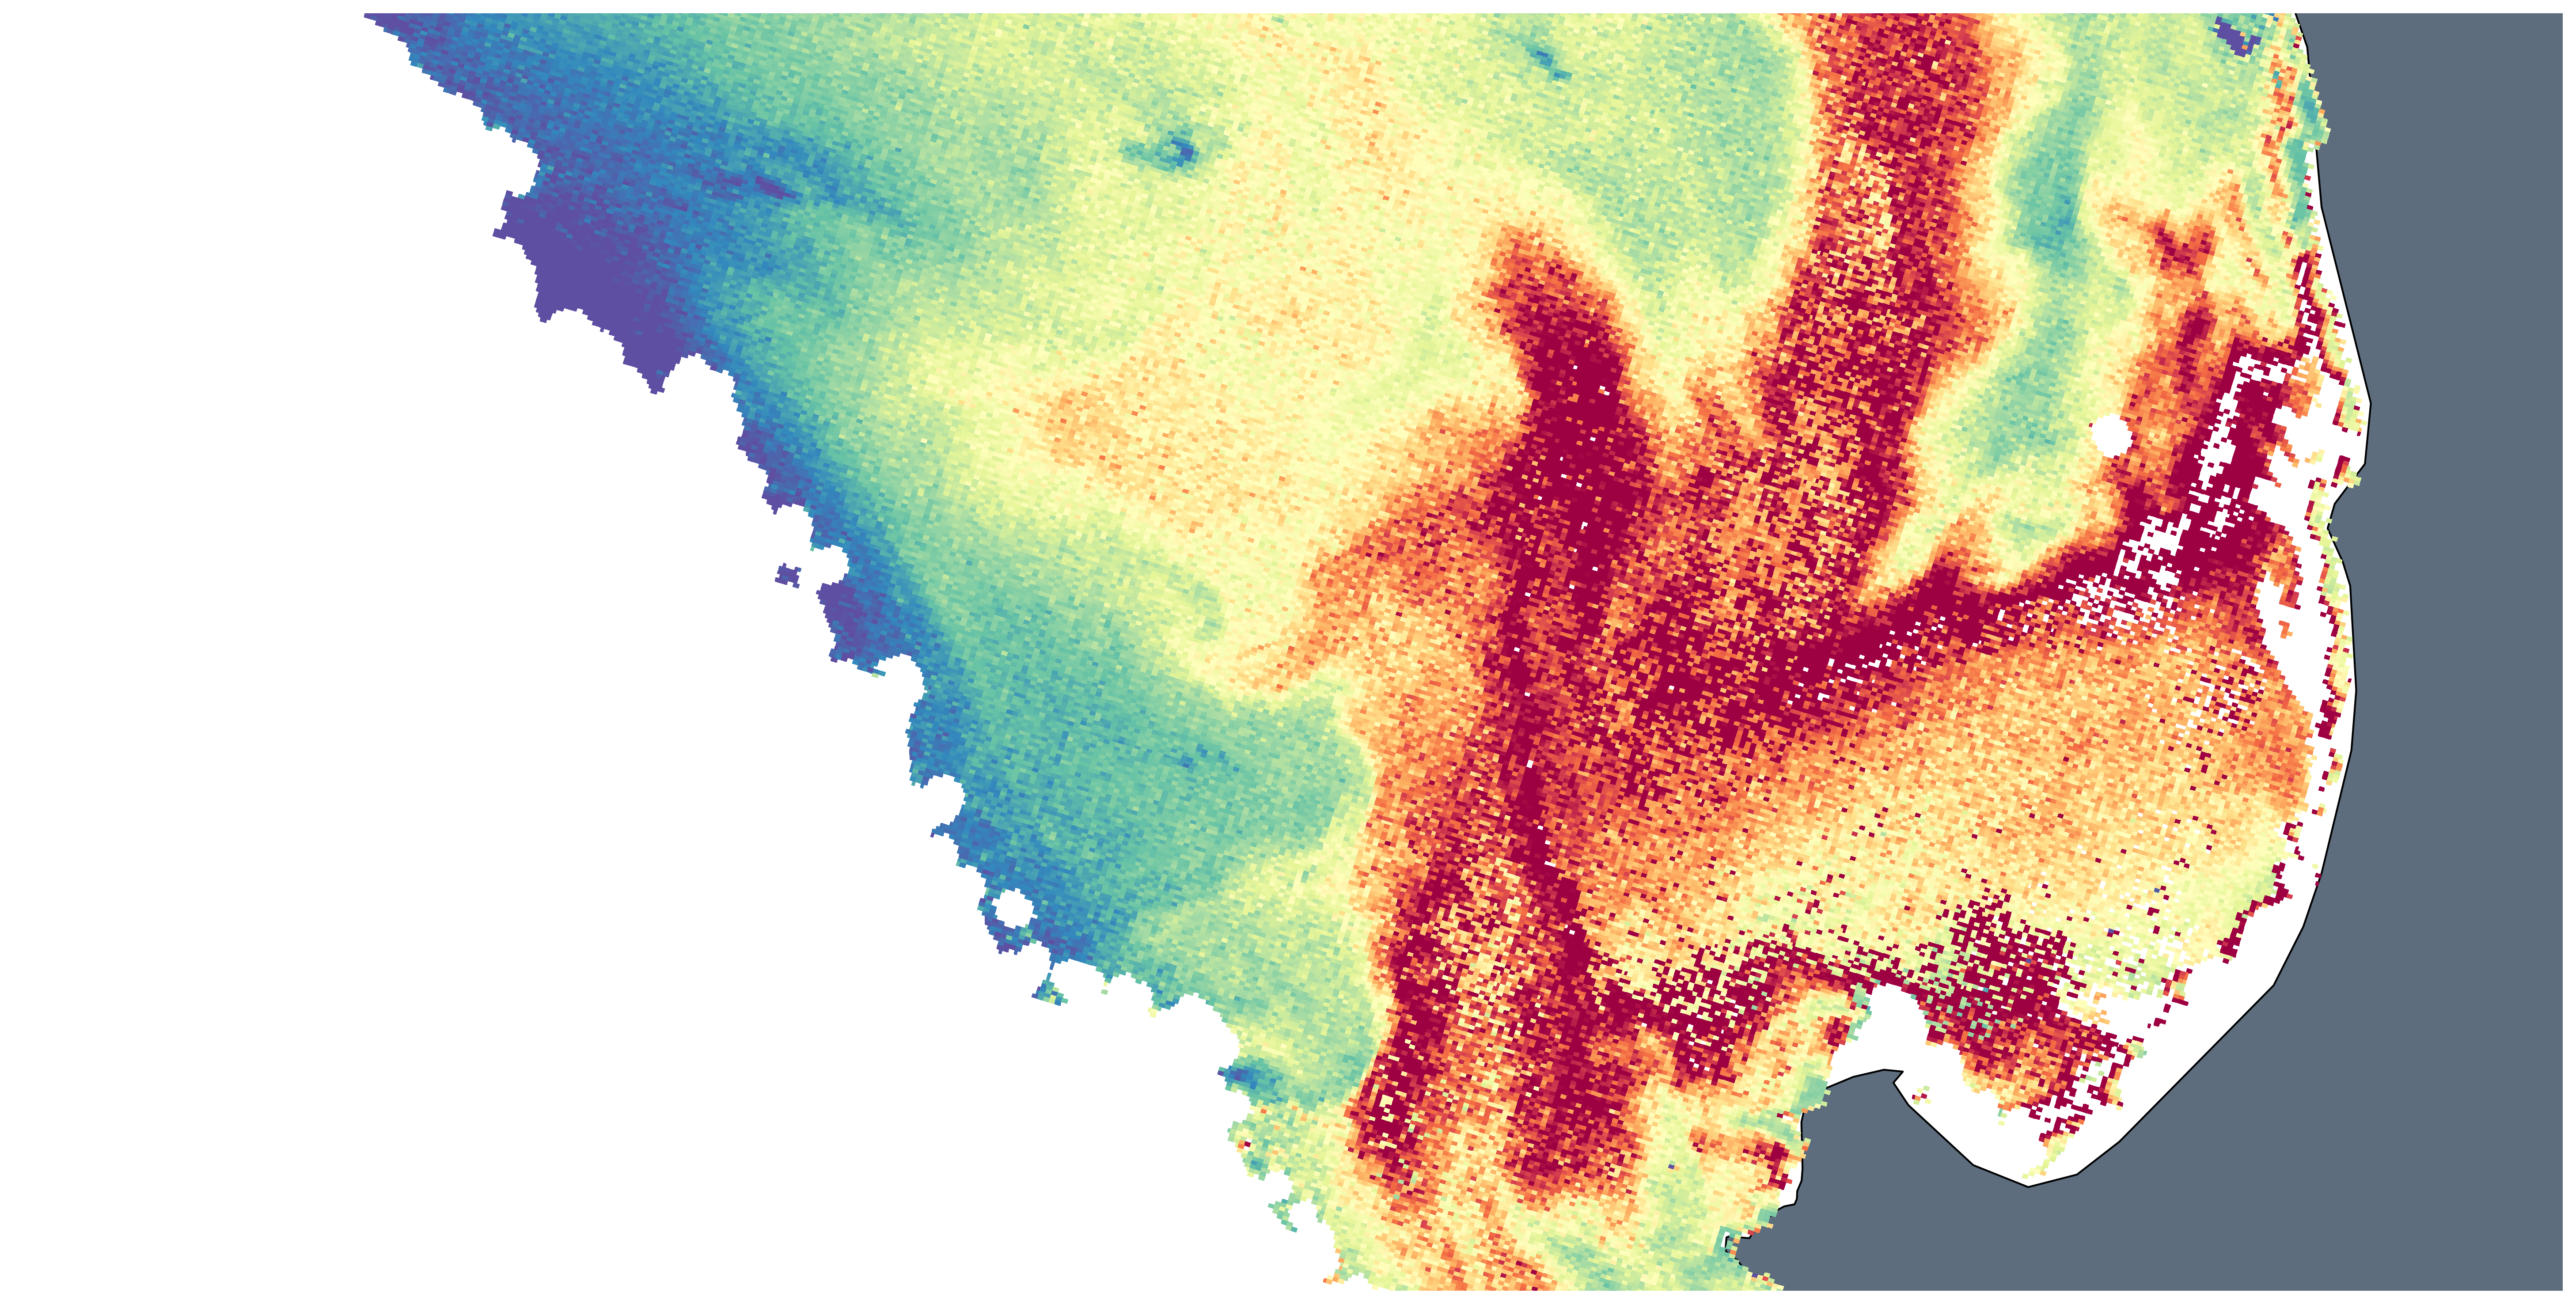

In [51]:
fig, m = plt.subplots(1, 1, figsize=(10, 14), dpi=300, subplot_kw={"projection": ccrs.Mercator()})

for chl, lon, lat, land_mask in zip(chls, lons, lats, land_masks):

    p1 = m.pcolormesh(lon, lat, chl, transform=ccrs.PlateCarree(), 
                       cmap=plt.cm.viridis, vmin=-1, vmax=2, zorder=1)

    m.contourf(lon, lat, land_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5', zorder=4)

at_x, at_y = m.projection.transform_point(18.3369, -32.3003, src_crs=ccrs.PlateCarree())

txt = m.annotate('Elandsbaai', xy=(at_x, at_y),  xycoords='data',
        xytext=(0.75, 0.45), textcoords='axes fraction', color='r',
        arrowprops=dict(arrowstyle="fancy", facecolor='black'),
        zorder=100, fontsize=18)

txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 0.25))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 0.25))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set_extent([min(subset_box_lons), max(subset_box_lons), min(subset_box_lats), max(subset_box_lats)])
m.axis('off')

plt.tight_layout()

cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
ticks = [-1,0,1,2]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**tick for tick in ticks])
cbar.set_label('Band switching (OC4ME <-> 665:709) derived Chlorophyll concentration [mg.m$^{-3}$]')
plt.savefig('Coastal_deoxygenation_South_African_red_tides_OLCI.png', bbox_inches='tight')

*Note that the band ratio algorithm is prone to stretching the colour scale due to outliers. The plot above is limited to only show values in the range specified by the colour bar.*

<hr>
<a href="../../../Index.ipynb"><< Index</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>